In [51]:
import torch
from torch.nn import ReLU

from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            preprocess_image,
                            recreate_image,
                            save_gradient_images,
                            format_np_output,
                            get_positive_negative_saliency)


class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
%matplotlib inline
def show_gradient_images(gradient):
    """
        Exports the original gradient image

    Args:
        gradient (np arr): Numpy array of the gradient with shape (3, 224, 224)
    """
    # Normalize
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    if isinstance(gradient, (np.ndarray, np.generic)):
        gradient = format_np_output(gradient)
        gradient = Image.fromarray(gradient)
    plt.imshow(gradient)

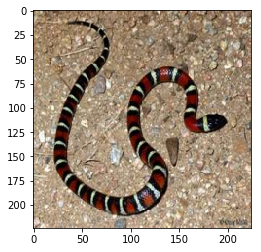

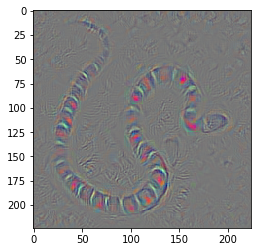

In [53]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) = get_example_params(target_example)
plt.figure()
plt.imshow(original_image)
GBP = GuidedBackprop(pretrained_model)
    # Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
plt.figure()
show_gradient_images(guided_grads)

In [97]:
from torch.optim import Adam
from torchvision import models
class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0


    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self, Quantization, bit=0):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Show image
            if i % 5 == 0:
                print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
                plt.figure()
                if Quantization == True:
                    self.created_image = np.round(np.round(np.array(self.created_image)/255*(2**bit-1))*255/(2**bit-1)).astype(int)
                plt.imshow(self.created_image)

Iteration: 5 Loss: -9.51
Iteration: 10 Loss: -42.10
Iteration: 15 Loss: -79.24
Iteration: 20 Loss: -119.76
Iteration: 25 Loss: -163.12
Iteration: 30 Loss: -208.88
Iteration: 5 Loss: -9.16
Iteration: 10 Loss: -39.21
Iteration: 15 Loss: -73.43
Iteration: 20 Loss: -110.07
Iteration: 25 Loss: -148.90
Iteration: 30 Loss: -190.04


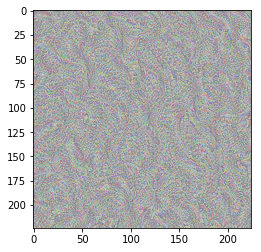

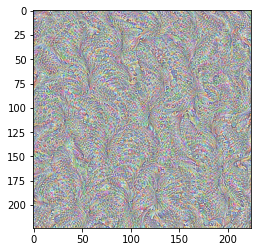

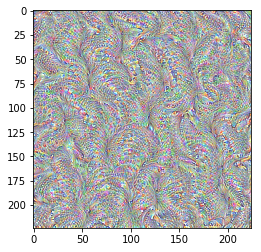

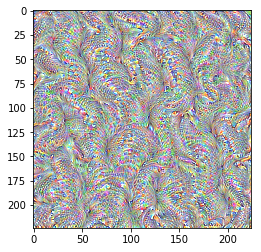

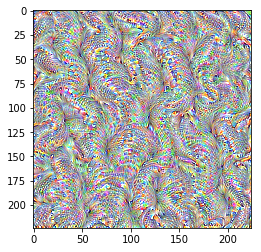

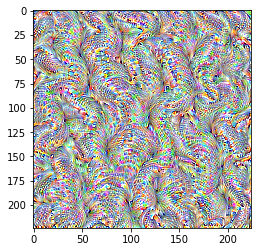

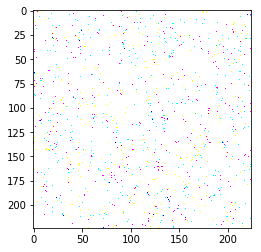

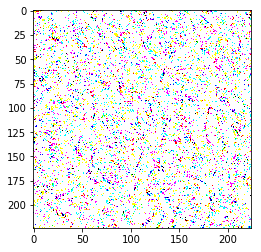

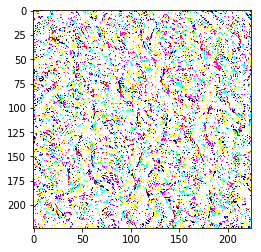

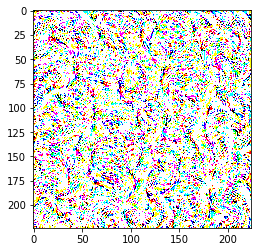

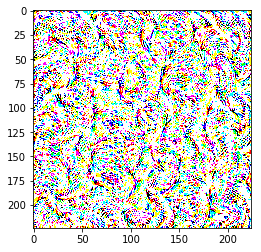

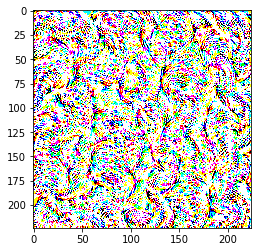

In [101]:
cnn_layer = 24
filter_pos = 2
# Fully connected layer is not needed
pretrained_model = models.vgg16(pretrained=True).features
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks(Quantization = False)
layer_vis.visualise_layer_with_hooks(Quantization = True, bit = 1)
